In [1]:
import requests_cache
requests_cache.install_cache('archive_cache')

In [2]:
from pymongo import MongoClient
import requests
from pathlib import Path
import pandas as pd
import glob
from PIL import Image
from io import BytesIO
from matplotlib.pyplot import imshow
import numpy as np
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import json
import magic
from IPython.display import JSON

In [3]:
mongo = MongoClient('172.17.0.1', 27017)
db = mongo['bad-vis']
posts = db['posts']
dlresults = db['dlresults']
dlerrorresults = db['dlerrorresults']

In [4]:
images_dir = Path('./images')

In [5]:
error_images = [r for r in dlresults.find({'request_status': {'$gte': 400}})]
len(error_images)

461

In [6]:
error_images[0]

{'_id': ObjectId('5e32eca53749cb9876488703'),
 'id': '21uju6',
 'post_id': 'reddit/dataisugly/21uju6',
 'link': 'http://www.newrepublic.com/sites/default/files/u18524/slide1_10.jpg',
 'dest': 'images/preview/reddit/dataisugly/21uju6',
 'request_status': 404,
 'status': 'not_found'}

In [7]:
r = requests.get(f"https://archive.org/wayback/available?url={error_images[0]['link']}")
r_json = r.json()
JSON(r_json)

<IPython.core.display.JSON object>

In [8]:
url = r_json['archived_snapshots']['closest']['url'].replace('/http', 'if_/http')
url

'http://web.archive.org/web/20150919171956if_/http://www.newrepublic.com/sites/default/files/u18524/slide1_10.jpg'

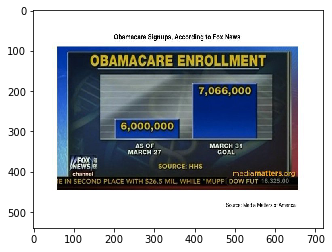

In [9]:
r = requests.get(url)
pil_image = Image.open(BytesIO(r.content))
imshow(np.asarray(pil_image))

In [38]:
def get_content_type_ext (content_type, req=None):
    content_type = content_type.lower()
    if content_type == 'image/jpeg' or content_type == 'image/jpg':
        return '.jpg'
    elif content_type == 'image/png':
        return '.png'
    elif content_type == 'image/gif':
        return '.gif'
    elif content_type == 'image/webp':
        return '.webp'
    elif content_type.startswith('image/svg'):
        return '.svg'
    elif content_type == 'image/*' and req:
        return get_content_type_ext(magic.from_buffer(req.content, mime=True))
    else:
        print(f'Unknow content-type: {content_type}')
        return ''

def download_image (post, t='preview', outdir=None):
    if t in post:
        if type(post[t]) == str:
            link = post[t]
        else:
            link = post[t]['url']
    else:
        link = ''
    if not outdir:
        outdir = t
    result = {
        'id': post['id'],
        'post_id': post['post_id'],
        'link': link,
        'dest': images_dir/outdir/post['post_id']
    }

    if len(glob.glob(f'{result["dest"]}.*')) != 0:
        result['status'] = 'exists'
        return result
    else:
        result['dest'].parent.mkdir(parents=True, exist_ok=True)
    
    if not link or link == 'None' or type(link) != str:
        result['status'] = 'invalid_url'
        return result
    
    try:
        archive_url = f"https://archive.org/wayback/available?url={link}"
        r = requests.get(archive_url)
        r_json = r.json()
        if 'closest' in r_json['archived_snapshots']:
            result['archive_link'] = r_json['archived_snapshots']['closest']['url'].replace('/http', 'if_/http')
            r = requests.get(result['archive_link'])
            result['archive_request_status'] = r.status_code
            if result['archive_request_status'] >= 400:
                result['archive_status'] = 'archive_error'
                return result
        else:
            result['archive_status'] = 'archive_not_found'
            return result

        result['ext'] = get_content_type_ext(r.headers.get('content-type'), r)
        if result['ext'] == '':
            result['status'] = 'invalid_content_type'
            print(f'id: {result["id"]} link: {result["link"]}')
            return result

        result['output'] = f'{result["dest"]}{result["ext"]}'
        with open(result['output'], 'wb') as f:
            f.write(r.content)
        result['status'] = 'downloaded'
        return result
    except Exception as inst:
        print(f"Download error: {post['post_id']} {link} {inst}")
        print(f"Archive: {post['post_id']} {archive_url}")
        result['status'] = 'download_error'
        return result
    
    return result

In [39]:
for post in [dlresults.find_one({'id': 'arj3mh'})]:
    result = download_image(post, t='link', outdir='archive')
    print(result)

Unknow content-type: text/html; charset=utf-8
id: arj3mh link: http://www.vairalm.com/live
{'id': 'arj3mh', 'post_id': 'reddit/dataisugly/arj3mh', 'link': 'http://www.vairalm.com/live', 'dest': PosixPath('images/archive/reddit/dataisugly/arj3mh'), 'archive_link': 'http://web.archive.org/web/20190626181508if_/http://vairalm.com:80/live', 'archive_request_status': 200, 'ext': '', 'status': 'invalid_content_type'}


In [40]:
def parallel (f, params_list, params_dict={}, total=None, n_jobs=-2):
    results = []
    with Parallel(n_jobs=n_jobs, require='sharedmem') as p:
        results = p(delayed(f)(params, **params_dict) for params in tqdm(params_list, total=total))
    return results

In [41]:
error_downloads = [p for p in dlresults.find() if not (p['status'] == 'downloaded' or p['status'] == 'exists' or 'skip_' in p['status'])]

In [42]:
dl_error_downloads_results = parallel(download_image, error_downloads, total=len(error_downloads), params_dict={'t': 'link', 'outdir': 'archive'})

Unknow content-type: text/html; charset=utf-16le
id: cpyyi1 link: https://www.visualcapitalist.com/wp-content/uploads/2019/07/investing-by-age-generations.html
Unknow content-type: text/html; charset=utf-8
id: arj3mh link: http://www.vairalm.com/live
Unknow content-type: text/html; charset=utf-8
id: ag4igb link: https://datasignals.io/data/slug/comparing-the-number-of-matches-of-the-top-10-fortnite-pubg-players-and-black-ops4-players-on-the-wins-leaderboard-609
Unknow content-type: text/html; charset=utf-8
id: ac7nfo link: https://datasignals.io/data/5c2e3e12ca4912298708dfa8
Unknow content-type: application/pdf
id: acyeio link: http://www.euchems.eu/wp-content/uploads/2018/10/Periodic-Table-ultimate-PDF.pdf
Unknow content-type: text/html; charset=utf-8
id: a8xfg3 link: https://datasignals.io/data/5c1fddffca4912298708df92
Unknow content-type: text/html; charset=utf-8
id: a8ap36 link: https://www.similarweb.com/blog/valentines-day-shopping
Unknow content-type: text/html; charset=utf-8
id

In [43]:
for r in dl_error_downloads_results:
    r['dest'] = str(r['dest'])

In [44]:
dlerrorresults.drop()
dlerrorresults.insert_many(dl_error_downloads_results)

In [45]:
results = [d for d in dl_error_downloads_results if 'status' in d and d['status'] == 'exists']
len(results)

76

In [46]:
results = [d for d in dl_error_downloads_results if 'archive_status' in d and d['archive_status'] == 'archive_not_found']
len(results)

526

In [47]:
[d for d in dlresults.find() if 'kent' in d['link']]

[{'_id': ObjectId('5e32eca53749cb987648875d'),
  'id': '5xz68l',
  'post_id': 'reddit/dataisugly/5xz68l',
  'link': 'https://www.kent.ac.uk/careers/pics/Future-Jobs-SM.png',
  'dest': 'images/preview/reddit/dataisugly/5xz68l',
  'request_status': 200,
  'ext': '',
  'status': 'invalid_content_type'}]